## Assessment Notebook_Group 6

Name: Quanzeyu Yang &nbsp;&nbsp; StudentID: 5980972\
Name: Ranran Zhang  &nbsp;&nbsp; StudentID: 5987971\
Name: Xinru Yu&nbsp;&nbsp;       StudentID: 5997073\
Name: Marco Waibel&nbsp;&nbsp;   StudentID: 6295680\
Name: DongKeon Kim&nbsp;&nbsp;            StudentID: 6328874

## Install the Packages

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data

## Download Data

In [4]:
# DOWNLOAD DATA

# only change the equity ticker strings if required
# don't change the variable name "tickers"
tickers = [ \
    'AAPL', # Apple
    'MSFT', # Microsoft
    'AMZN', # Amazon
    '^GSPC'] # S&P500 - Benchmark

# only change string values if required
# don't change the two variable names "start_date" and "end_date"
start_date = '2010-01-01'
end_date = '2023-06-14'

# download the time series of adj. close price
# for each of the tickers from Yahoo finance
# in case you receive an error go through this:
## https://stackoverflow.com/questions/74832296/typeerror-string-indices-must-be-integers-when-getting-data-of-a-stock-from-y
price_data = {}

for ticker in tickers:
    price_data[ticker] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

# create dataframe with one row per day and adj. close price for each of the tickers
# and dataframe with price changes
df_prices = pd.concat([price_data[ticker].rename(ticker) for ticker in tickers], axis=1)
prev = df_prices.to_numpy()
prev = prev / np.insert(prev[:-1,:], 0, np.ones(prev.shape[1]), 0)
prev[0] = np.ones(prev.shape[1])
df_price_changes = df_prices.copy(deep=True)
df_price_changes[:] = prev

# print dataframes
print(df_prices)
print(df_price_changes)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  AAPL        MSFT        AMZN        ^GSPC
Date                                                       
2010-01-04    6.496294   23.572361    6.695000  1132.989990
2010-01-05    6.507526   23.579981    6.734500  1136.520020
2010-01-06    6.404015   23.435274    6.612500  1137.140015
2010-01-07    6.392177   23.191557    6.500000  1141.689941
2010-01-08    6.434675   23.351492    6.676000  1144.979980
...                ...         ...         ...          ...
2023-06-07  177.820007  323.380005  121.230003  4267.520020
2023-06-08  180.570007  325.260010  124.250000  4293.930176
2023-06-09  180.960007  326.790009  123.430000  4298.859863
2023-06-12  183.789993  331.850006  126.570000  4338.930176
2023

## Define the Moving Average Function

In [5]:
# define the Moving average crossover 
def moving_avg_crossover(prices, window_length):
# set the size of moving average series
    T = len(prices)
    moving_avg = np.zeros(T)  
    moving_avg[:] = np.nan 
# calculate the average by moving time period
    for n in range(window_length, T):
      moving_avg[n] = np.sum(prices[n-window_length:n]) / window_length
    return moving_avg 

## Define the Standard Deviation

In [6]:
# calculate the standard deviation of moving average for Bollinger bands
def standard_deviation(prices, moving_avg_crossover):
    std= (((prices - moving_avg_crossover)**2)**0.5)
    return std

## Define other necessary Functions

In [7]:
# calculate the mean
def cal_mean(inputs):
    return np.sum(inputs) / len(inputs) 

# calculate standard deviation
def cal_std(inputs):
    return np.sqrt(np.sum(np.square(inputs - cal_mean(inputs))) / len(inputs))

# calculate log returns
def log_return(inputs):
    return np.log(inputs).diff() 

def calculate_excess_average(df):
    """
    Calculate the average daily return in excess of a risk-free rate
    """
    return df.mean()

def calculate_std_dev(df):
    """
    Calculate the standard deviation of daily returns using the formula you provided
    """
    avg = df.mean()
    var = sum(pow(x-avg,2) for x in df) / len(df)
    return np.sqrt(var)

def calculate_sharpe_ratio(df):
    """
    Calculate the Sharpe ratio for each strategy
    """
    # Calculate average excess return
    excess_average = calculate_excess_average(df)

    # Calculate standard deviation
    std_dev = df.apply(calculate_std_dev, axis=0)

    # Calculate Sharpe ratio
    sharpe_ratio = excess_average / std_dev

    return sharpe_ratio

## 1. Signal 0: Moving Average Crossover


In [8]:
### SIGNAL 0

def signal_0(series):
    # Init
    signals = pd.DataFrame(index = series.index) 
    signals['signal'] = 0.0 
    
    # Compute simple moving average for short-term and long-term
    short_window = 20
    long_window = 100
    signals['short_ma'] = moving_avg_crossover(series, short_window)
    signals['long_ma'] = moving_avg_crossover(series, long_window)

    # Compute signals: buys and sells
    signals['buy']= np.where(signals['short_ma']> signals['long_ma'], 1.0, 0.0)  
    signals['sell'] = np.where(signals['short_ma']< signals['long_ma'], -1.0, signals['signal'])

    # modify the real signals in order to do not generate sell signals when there were no buy signals before,
    # and in order to record the real buy, holding, sell signals
    # if previos signal is 0 and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 0) & (signals['buy'] == 1), 1, signals['signal'])
    # if previos signal is 0 and sell signal occurs in the current, do not sell the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 0) & (signals['sell'] ==-1), 0,signals['signal'] )
    # if previos signal is buy and sell signal occurs in the current, sell the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 1) & (signals['sell'] == -1), -1, signals['signal'])
    # if previos signal is 0 and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 1) & (signals['buy'] == 1), 1, signals['signal'])
    # if previos signal is sell and sell signal occurs in the current, return zero, do not sell when there were no buy signal before
    signals['signal'] = np.where((signals['signal'].shift(1) == -1) & (signals['sell'] == -1), 0, signals['signal'])
    # if previos signal is sell and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == -1) & (signals['buy'] == 1), 1, signals['signal'])
    
    # compute the position_change in order to deliver it to portflio allocation
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals

## 2. Signal 1: Bollinger Bands 

In [9]:
def signal_1(series):
    # Initial Dataframe
    signals = pd.DataFrame(index = series.index) 
    signals['signal'] = 0.0 
    # calculate the middle line: moving average
    mid_window=20
    signals['mid_line'] = moving_avg_crossover(series, mid_window)
    # calculate the moving standard deviation
    signals['std'] = standard_deviation(series, signals['mid_line'])
    signals['moving_avg_std'] = moving_avg_crossover(signals['std'], mid_window)
    # calculate the upper band
    signals['upper_line'] = moving_avg_crossover(series, mid_window)+(2*signals['moving_avg_std'])
    # calculate the lower band
    signals['lower_line'] = moving_avg_crossover(series, mid_window)-(2*signals['moving_avg_std'])
    
    # Compute signals: buys and sells
    signals['buy'] = np.where(series < signals['lower_line'] , 1.0, 0.0)   
    signals['sell'] = np.where(series > signals['upper_line'], - 1.0, signals['signal'])
    
    # modify the real signals in order to do not generate sell signals when there were no buy signals before,
    # and in order to record the real buy, holding, sell signals
    # if previos signal is 0 and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 0) & (signals['buy'] == 1), 1, signals['signal'])
    # if previos signal is 0 and sell signal occurs in the current, do not sell the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 0) & (signals['sell'] ==-1), 0,signals['signal'] )
    # if previos signal is buy and sell signal occurs in the current, sell the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 1) & (signals['sell'] == -1), -1, signals['signal'])
    # if previos signal is 0 and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 1) & (signals['buy'] == 1), 1, signals['signal'])
    # if previos signal is sell and sell signal occurs in the current, return zero, do not sell when there were no buy signal before
    signals['signal'] = np.where((signals['signal'].shift(1) == -1) & (signals['sell'] == -1), 0, signals['signal'])
    # if previos signal is sell and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == -1) & (signals['buy'] == 1), 1, signals['signal'])
    
    # compute the position_change in order to deliver it to portflio allocation
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0


    return signals

## 3. Signal 2: Relative Strength Index

In [10]:

def signal_2(series):
    signals = pd.DataFrame(index = series.index)
    signals['signal'] = 0.0
    # Set the window period as 14 days
    window_period = 14 
    signals['price']=series
    signals['prices_diff'] = series.diff()
    # calculate the gain and loss during the lookback period
    # for the gain history within the lookback period (0 if there is no gain, and the magnitude of gain if there is gain)
    signals['up'] = np.where(signals['prices_diff'] > 0, signals['prices_diff'], 0.0)
    # for the loss history within the lookback period (0 if there is no loss, and the magnitude of loss if there is loss)
    signals['down'] = np.where(signals['prices_diff'] < 0, np.abs(signals['prices_diff']), 0.0)
    # set the lookback period as 14 days, a half of 28 days also support the results
    signals['avg_up'] = moving_avg_crossover(signals['up'], window_period)
    signals['avg_down'] = moving_avg_crossover(signals['down'], window_period)

    # Compute signals
    # calculate RS, and then RSI
    signals['RS'] =  signals['avg_up'] / signals['avg_down']  
    signals['RSI'] = 100 - (100 / (1.0 + signals['RS']))
    # Generate signals
    
    signals['buy'] = np.where(signals['RSI'] < 30 , 1.0, 0.0)        
    # derive position change directly from signal 
    signals['sell'] = np.where(70 < signals['RSI'] , -1.0, signals['signal'])
    
    # modify the real signals in order to do not generate sell signals when there were no buy signals before,
    # and in order to record the real buy, holding, sell signals
    # if previos signal is 0 and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 0) & (signals['buy'] == 1), 1, signals['signal'])
    # if previos signal is 0 and sell signal occurs in the current, do not sell the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 0) & (signals['sell'] ==-1), 0,signals['signal'] )
    # if previos signal is buy and sell signal occurs in the current, sell the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 1) & (signals['sell'] == -1), -1, signals['signal'])
    # if previos signal is 0 and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == 1) & (signals['buy'] == 1), 1, signals['signal'])
    # if previos signal is sell and sell signal occurs in the current, return zero, do not sell when there were no buy signal before
    signals['signal'] = np.where((signals['signal'].shift(1) == -1) & (signals['sell'] == -1), 0, signals['signal'])
    # if previos signal is sell and buy signal occurs in the current, buy the stock
    signals['signal'] = np.where((signals['signal'].shift(1) == -1) & (signals['buy'] == 1), 1, signals['signal'])
    
    # compute the position_change in order to deliver it to portflio allocation
    signals['position_change'] = signals['signal'].diff()
    signals.loc[series.index[0], 'position_change'] = 0
    return signals


## Compute 3 signals together

In [11]:
# Compute signals
signals = {}
# Moving average crossover for AAPL
signals[tickers[0]] = signal_0(df_prices[tickers[0]])
# Bollinger band for MSFT
signals[tickers[1]] = signal_1(df_prices[tickers[1]])
# RSI for AMZN
signals[tickers[2]] = signal_2(df_prices[tickers[2]])
df_position_open = pd.concat([
    signals[tickers[0]]['signal'].rename(tickers[0]),
    signals[tickers[1]]['signal'].rename(tickers[1]),
    signals[tickers[2]]['signal'].rename(tickers[2])], axis = 1)
df_position_changes = pd.concat([
    signals[tickers[0]]['position_change'].rename(tickers[0]),
    signals[tickers[1]]['position_change'].rename(tickers[1]),
    signals[tickers[2]]['position_change'].rename(tickers[2])], axis = 1)

## Portfolio Allocation

In [12]:
# ALLOCATE CAPITAL AND COMPUTE RESULTING POSITIONS
initial_cash = 1.0
capital_fraction_per_trade = 0.05

# DO NOT MODIFY THIS CELL BELOW THIS LINE
position = []

def open_trades(position, position_change):
    vec = np.maximum([position_change[ticker] for ticker in tickers[:-1]], [0])
    vec = position[-1] * (1 - np.power((1 - capital_fraction_per_trade), np.sum(vec))) * vec / (1 if (np.nansum(vec) == 0.0) else np.nansum(vec))
    return np.append(vec + position[:-1], position[-1] - np.sum(vec))

def hold_trades(position, price_change):
    return np.concatenate((position[:-1] * price_change[:-1], [position[-1]]))

def close_trades(position, position_change):
    vec = np.concatenate((np.array([position_change[ticker] < 0.0 for ticker in tickers[:-1]]), [False]))
    position[-1] = position[-1] + np.sum(position[vec])
    position[vec] = 0.0
    return position
    
is_first = True
for idx, position_change in df_position_changes.iterrows():
    if is_first:
        position.append(open_trades(np.concatenate((np.zeros(len(df_position_changes.columns)), [initial_cash])), position_change))
        is_first = False
    else:
        hlpr_pos = hold_trades(position[-1], df_price_changes.loc[[idx]].to_numpy()[0])
        hlpr_pos = close_trades(hlpr_pos, position_change)
        position.append(open_trades(hlpr_pos, position_change))

df_position = pd.DataFrame(position, index = df_prices.index, columns = tickers[:-1] + ['cash'])

## Statistics Part

In [13]:
# COMPUTE MEANINGFUL STATISTICS OF YOUR STRATEGY
# YOU ARE FREE TO CHOOSE MEASURES

# REMEMBER THAT YOU MAY NOT USE READY-TO-USE FUNCTIONS
# WHEN IN DOUBT - CODE A FUNCTION ON YOUR OWN!
# EXAMPLE: .mean() and .std() are ready-to-use, that's why they are implemented below

returns = df_position.sum(axis=1)
returns = (returns[1:].to_numpy() / returns[:-1].to_numpy()) - 1
mean_returns = np.sum(returns) / len(returns)
std_returns = np.sqrt(np.sum(np.square(returns - mean_returns)) / len(returns))
print('Annualized mean: ' + str(mean_returns * 250))
print('Annualized std:  ' + str(std_returns * np.sqrt(250)))



Annualized mean: 0.02986025196416671
Annualized std:  0.03220002530553832


## Plotting

### 1.Singnal 0: Moving Average

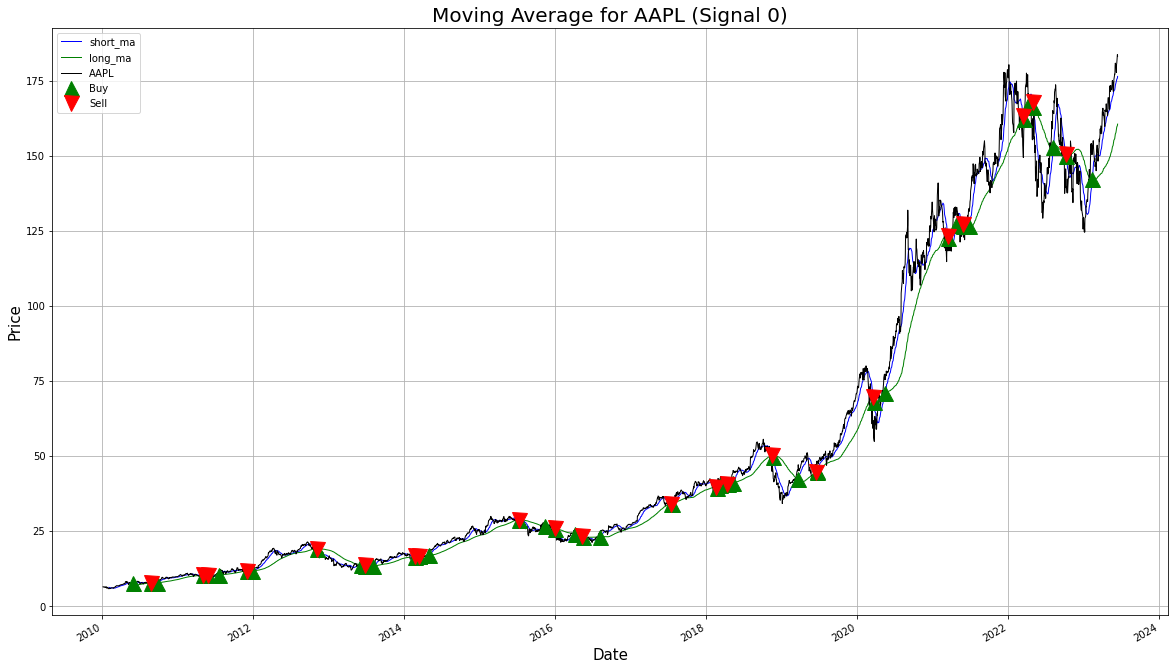

In [14]:
# Select the APPL ticker for signal 0
appl_prices = df_prices['AAPL']
signals = signal_0(appl_prices)

# plotting
plt.figure(figsize=(20, 12))
signals['short_ma'].plot(color='blue', lw=1, label='short_ma')
signals['long_ma'].plot(color='green', lw=1, label='long_ma')
appl_prices.plot(color='black', lw=1, label='AAPL')

# Plot 'buy' signals
buy_signals = signals[signals['signal'].diff() == 1]
plt.plot(buy_signals.index.tolist(), buy_signals['short_ma'].to_numpy(), '^', markersize=15, color='g', label='Buy')

# Plot 'sell' signals
sell_signals = signals[signals['signal'] == -1]
plt.plot(sell_signals.index.tolist(), sell_signals['long_ma'].to_numpy(), 'v', markersize=15, color='r', label='Sell')

plt.ylabel('Price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('Moving Average for AAPL (Signal 0)', fontsize = 20)
plt.legend()
plt.grid()

plt.show()

### 2.Singnal 1: Bollinger Bands

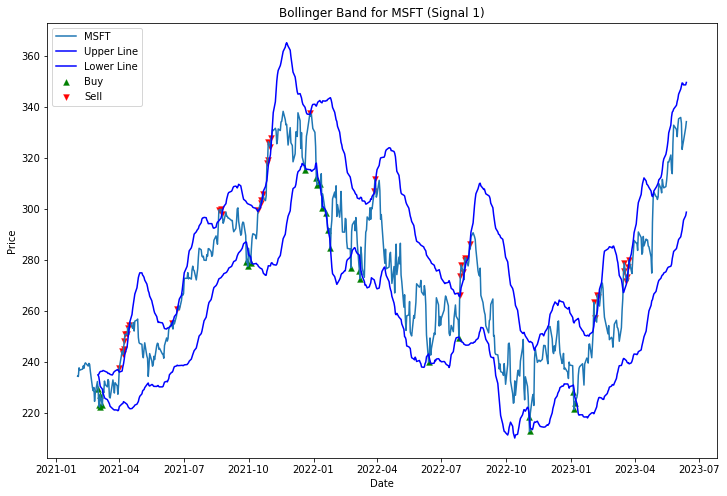

In [15]:
# Select the MSFT ticker for Signal 1
msft_prices = df_prices['MSFT'].loc['2021-02-01':]

# Compute Signal 1 for MSFT
signals = signal_1(msft_prices)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the series
ax.plot(msft_prices.index, msft_prices, label='MSFT')

# Plot the upper and lower lines
ax.plot(signals.index, signals['upper_line'], label='Upper Line', color='b')
ax.plot(signals.index, signals['lower_line'], label='Lower Line', color='b')

# Plot the buy signals
buy_signals = signals[signals['buy'] == 1]
ax.scatter(buy_signals.index, msft_prices.loc[buy_signals.index], color='g', marker='^', label='Buy', linewidth=0.3)

# Plot the sell signals
sell_signals = signals[signals['sell'] == -1]
ax.scatter(sell_signals.index, msft_prices.loc[sell_signals.index], color='r', marker='v', label='Sell', linewidth=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Bollinger Band for MSFT (Signal 1)')
ax.legend()

plt.show()

### 3. Signal 2: RSI

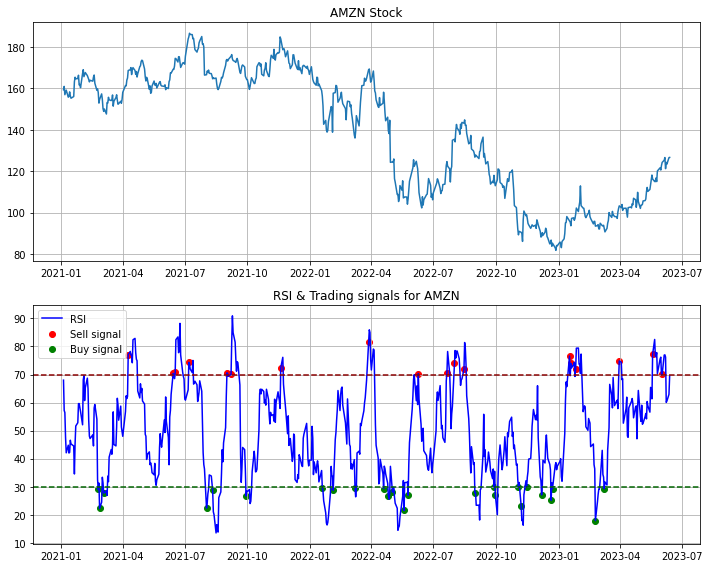

In [16]:
# Calculate the signals
amzn_signals = signal_2(df_prices['AMZN'])

# Start for the graphs 
amzn_signals = amzn_signals.loc['2021-01-01':]

# Create 2 graphs (Stock and RSI)
fig, ax = plt.subplots(2, 1, figsize=(10,8))

# Showing stock prices
ax[0].plot(amzn_signals.index, amzn_signals['price'], label='Price')
ax[0].set_title('AMZN Stock')
ax[0].grid()

# Parameter for buy and sell signal
prev_rsi = amzn_signals['RSI'].shift(1)
buy = (amzn_signals['RSI'] < 30) & (prev_rsi >= 30)
sell = (amzn_signals['RSI'] > 70) & (prev_rsi <= 70)

# Showing RSI on second graph
ax[1].plot(amzn_signals.index, amzn_signals['RSI'], label='RSI', color='blue')

# Red marker for sell 
ax[1].scatter(amzn_signals[sell].index, amzn_signals[sell]['RSI'], color='red', label='Sell signal')

# Green marker for buy
ax[1].scatter(amzn_signals[buy].index, amzn_signals[buy]['RSI'], color='green', label='Buy signal')

# Create barrier (30 and 70)
ax[1].axhline(30, color='darkgreen', linestyle='--')
ax[1].axhline(70, color='darkred', linestyle='--')

ax[1].set_title('RSI & Trading signals for AMZN')
ax[1].grid()

ax[1].legend(loc='upper left')

# Output
plt.tight_layout()
plt.show()


## Portfolio

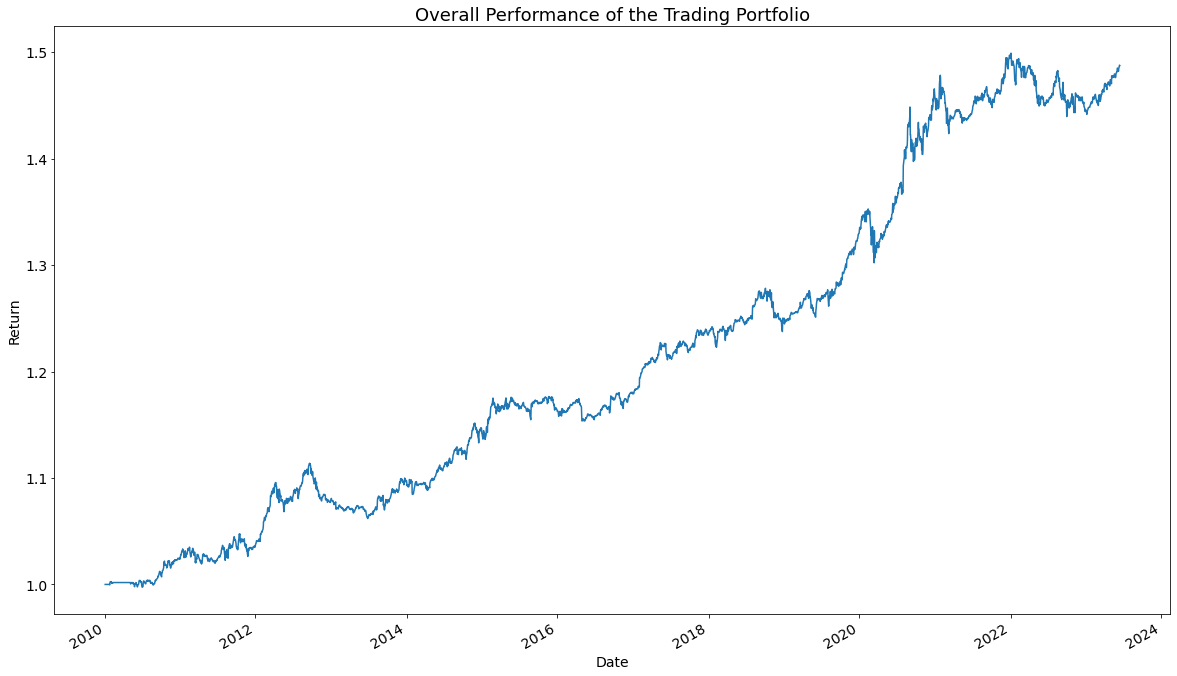

In [17]:
# COMPUTE MEANINGFUL PLOTS OF YOUR STRATEGY AND LABEL IT IN AN UNDERSTANDABLE WAY
df_position.sum(axis=1).plot(figsize=(20,12))
plt.title("Overall Performance of the Trading Portfolio",fontsize= 18)
plt.xlabel("Date", fontsize = 14)
plt.xticks(fontsize=14)
plt.ylabel("Return", fontsize = 14)
plt.yticks(fontsize=14)
plt.show()

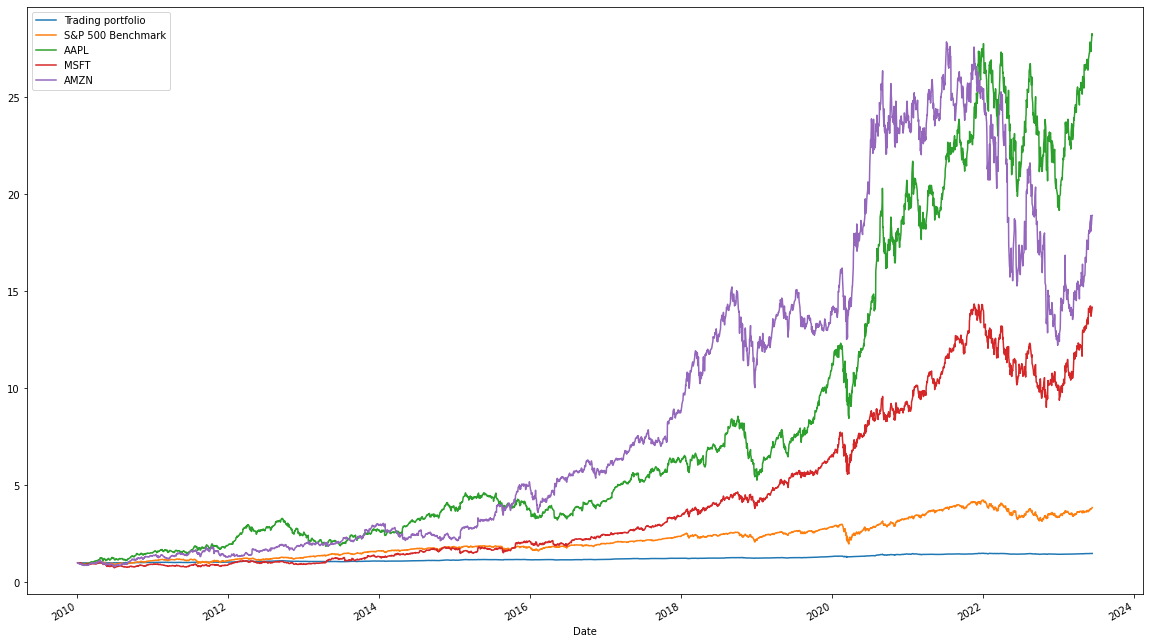

In [18]:
# Plotting the portfolio return against S&P 500 Index and the single stock returns (based on the first day in the data set)

# Take the stock prices and divide them by the first element in the time frame to get the percentage return
df_position.sum(axis=1).plot(label= 'Trading portfolio', linestyle= 'solid', figsize = (20, 12))
(df_prices['^GSPC']/(df_prices['^GSPC'][0])).plot(label= 'S&P 500 Benchmark', linestyle= 'solid')
(df_prices[tickers[0]]/(df_prices[tickers[0]][0])).plot(label= tickers[0], linestyle= 'solid')
(df_prices[tickers[1]]/(df_prices[tickers[1]][0])).plot(label= tickers[1], linestyle = 'solid')
(df_prices[tickers[2]]/(df_prices[tickers[2]][0])).plot(label= tickers[2], linestyle = 'solid')
plt.legend()

## Performance Measurement - Sharpe Ratio 

In [19]:
#caculate the annual standard deviation
def calculate_annual_std(df, trading_days=252):
    std_data = {}
    for column in df:
        mean = df[column].mean()
        diff_squared = [(x - mean) ** 2 for x in df[column]]
        variance = sum(diff_squared) / len(df[column])
        std_dev = (variance ** 0.5) * (trading_days ** 0.5)  # annualizing std
        std_data[column] = std_dev
    return std_data

annual_std_dev = calculate_annual_std(df_price_changes)
print(annual_std_dev)

{'AAPL': 0.2851526939601378, 'MSFT': 0.26084014049708004, 'AMZN': 0.3314306101824793, '^GSPC': 0.17712612396160154}


In [20]:
# download 5-year US treasury yield as the risk-free rate
risk_free_rate = yf.download('^FVX', start=start_date, end=end_date)['Adj Close'] 
# convert to daily returns
risk_free_rate = log_return(risk_free_rate)#risk_free_rate.pct_change() + 1 
# annualize the risk-free rate
annual_rf_rate = cal_mean(risk_free_rate)**250 - 1
print (risk_free_rate)


[*********************100%***********************]  1 of 1 completed
Date
2010-01-04         NaN
2010-01-05   -0.036088
2010-01-06    0.005847
2010-01-07    0.010439
2010-01-08   -0.013163
                ...   
2023-06-07    0.016206
2023-06-08   -0.016206
2023-06-09    0.016461
2023-06-12   -0.000766
2023-06-13    0.026205
Name: Adj Close, Length: 3381, dtype: float64


In [21]:
df_sharpe= df_position.resample('Y').mean()
df_sharpe['sum']= df_sharpe.sum(axis=1)
df_sharpe['return']=df_sharpe['sum']/df_sharpe['sum'].shift() -1

# adding the annual risk free rate
df_sharpe = pd.merge(df_sharpe, risk_free_rate, left_on= df_sharpe.index, right_on = risk_free_rate.index)
df_sharpe.set_index ('key_0', inplace = True)

# creating data frame
df_position_sharpe = df_position.copy()
df_position_sharpe['sum']= df_position_sharpe.sum(axis=1)

# adding the year collumn
df_position_sharpe['year']=df_position_sharpe.index.year
df_sharpe['year']=df_sharpe.index.year

# copy index 
df_position_sharpe['index']=df_position_sharpe.index

# Merge sharpe
df_position_sharpe = pd.merge(df_position_sharpe, df_sharpe[['year', 'sum']], on ='year', how = 'left' )
# Resetting index
df_position_sharpe.set_index('index', inplace= True)

# calculating the std dev.
df_position_sharpe['std']= standard_deviation(df_position_sharpe['sum_x'], df_position_sharpe['sum_y'])

# Resampeling
df_sharpe['std']=df_position_sharpe['std'].resample('Y').mean()

# calculating the sharp ratio
df_sharpe['Sharpe_ratio']= (df_sharpe['return']- (df_sharpe['Adj Close']/100))/df_sharpe['std']

# renaming the columns
df_sharpe = df_sharpe.rename (columns = {"sum": "portfolio_value", 'return': 'return_per_year', 'Adj Close': 'risk_free_rate%'})

Sharpe_ratio = cal_mean(df_sharpe)

print(Sharpe_ratio)

AAPL                  0.120882
MSFT                  0.001989
AMZN                  0.003334
cash                  1.074138
portfolio_value       1.200344
return_per_year       0.034448
risk_free_rate%      -0.009617
year               2015.777778
std                   0.014162
Sharpe_ratio          2.752230
dtype: float64
